In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/normalizing-flows"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/normalizing-flows


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from flows import Flow
from flows.affine import Planar, Radial
from flows.sylvester import TriangularSylvester
from models.vae import GatedConvVAE

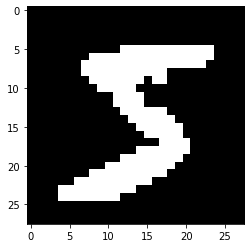

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train > 0).astype(np.float32)
X_test = (X_test > 0).astype(np.float32)
plt.imshow(X_train[0], cmap='gray')
x_train = np.expand_dims(X_train, axis=-1)

In [3]:
def plot_images(x_test, x_pred):
    plt.subplot(2,4,1)
    plt.imshow(x_test[0], cmap='gray')
    plt.subplot(2,4,2)
    plt.imshow(x_test[1], cmap='gray')
    plt.subplot(2,4,3)
    plt.imshow(x_test[2], cmap='gray')
    plt.subplot(2,4,4)
    plt.imshow(x_test[3], cmap='gray')
    plt.subplot(2,4,5)
    plt.imshow(x_pred[0].squeeze(), cmap='gray')
    plt.subplot(2,4,6)
    plt.imshow(x_pred[1].squeeze(), cmap='gray')
    plt.subplot(2,4,7)
    plt.imshow(x_pred[2].squeeze(), cmap='gray')
    plt.subplot(2,4,8)
    plt.imshow(x_pred[3].squeeze(), cmap='gray')
    plt.show()

In [ ]:
def 

In [4]:
def train_vae(x_train, flow=None, z_size=32, n_epochs=10):
    beta_update = lambda i, beta: 1.0E-1*(i+1)
    vae = GatedConvVAE(x_train.shape[1], x_train.shape[2], flow, z_size=z_size, beta_update_fn=beta_update)
    vae.fit(x_train, x_train, epochs=n_epochs, batch_size=128)
    return vae

### Vanilla VAE

In [5]:
vae = train_vae(x_train)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 173us/sample - loss: 0.2188
Epoch 2/10
60000/60000 [==============================] - 6s 97us/sample - loss: 0.1328
Epoch 3/10
60000/60000 [==============================] - 6s 98us/sample - loss: 0.1209
Epoch 4/10
60000/60000 [==============================] - 6s 97us/sample - loss: 0.1147
Epoch 5/10
60000/60000 [==============================] - 6s 97us/sample - loss: 0.1108
Epoch 6/10
60000/60000 [==============================] - 6s 98us/sample - loss: 0.1079
Epoch 7/10
60000/60000 [==============================] - 6s 98us/sample - loss: 0.1055
Epoch 8/10
60000/60000 [==============================] - 6s 97us/sample - loss: 0.1036
Epoch 9/10
60000/60000 [==============================] - 6s 97us/sample - loss: 0.1021
Epoch 10/10
60000/60000 [==============================] - 6s 98us/sample - loss: 0.1007


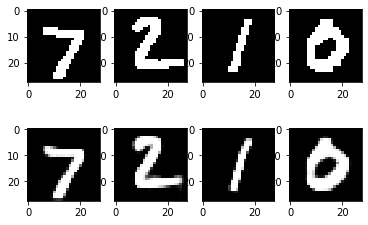

In [6]:
x_test = np.expand_dims(X_test, axis=-1)
x_pred = vae.predict(x_test)
plot_images(x_test.squeeze(), x_pred)

### Planar VAE

In [7]:
n_flows = 5
planar_flow = Flow(n_flows, lambda i: Planar())
planar_vae = train_vae(x_train, planar_flow)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 12s 200us/sample - loss: 0.2091
Epoch 2/10
60000/60000 [==============================] - 8s 127us/sample - loss: 0.1277
Epoch 3/10
60000/60000 [==============================] - 8s 126us/sample - loss: 0.1164
Epoch 4/10
60000/60000 [==============================] - 7s 124us/sample - loss: 0.1107
Epoch 5/10
60000/60000 [==============================] - 7s 124us/sample - loss: 0.1069
Epoch 6/10
60000/60000 [==============================] - 7s 124us/sample - loss: 0.1040
Epoch 7/10
60000/60000 [==============================] - 8s 127us/sample - loss: 0.1019
Epoch 8/10
60000/60000 [==============================] - 8s 125us/sample - loss: 0.1001
Epoch 9/10
60000/60000 [==============================] - 8s 125us/sample - loss: 0.0986
Epoch 10/10
60000/60000 [==============================] - 8s 125us/sample - loss: 0.0973


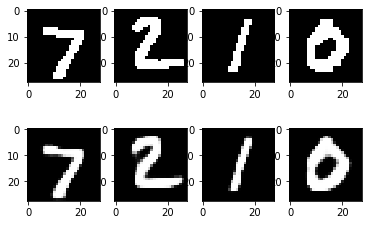

In [8]:
x_test = np.expand_dims(X_test, axis=-1)
x_pred = planar_vae.predict(x_test)
plot_images(x_test.squeeze(), x_pred)

### Triangular Sylvester VAE

In [9]:
n_flows = 5
tsnf_flow = Flow(n_flows, lambda i: TriangularSylvester(flip_z = i % 2 != 0))
tsnf_vae = train_vae(x_train, tsnf_flow)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 15s 250us/sample - loss: 0.1944
Epoch 2/10
60000/60000 [==============================] - 10s 168us/sample - loss: 0.1178
Epoch 3/10
60000/60000 [==============================] - 10s 168us/sample - loss: 0.1071
Epoch 4/10
60000/60000 [==============================] - 10s 166us/sample - loss: 0.1011
Epoch 5/10
60000/60000 [==============================] - 10s 165us/sample - loss: 0.0975
Epoch 6/10
60000/60000 [==============================] - 10s 168us/sample - loss: 0.0950
Epoch 7/10
60000/60000 [==============================] - 10s 167us/sample - loss: 0.0930
Epoch 8/10
60000/60000 [==============================] - 10s 167us/sample - loss: 0.0915
Epoch 9/10
60000/60000 [==============================] - 10s 168us/sample - loss: 0.0903
Epoch 10/10
60000/60000 [==============================] - 10s 169us/sample - loss: 0.0893


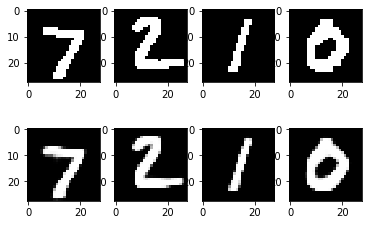

In [10]:
x_test = np.expand_dims(X_test, axis=-1)
x_pred = tsnf_vae.predict(x_test)
plot_images(x_test.squeeze(), x_pred)

In [ ]:
z_mu, z_log_sigma, params = vae.encoder.predict(x_test[10:11])
plt.figure(figsize=(4*6,2*4))
for i in range(1,9):
    x_pred = vae.decoder.predict([z_mu, z_log_sigma, params])
    plt.subplot(2,4,i)
    plt.imshow(tf.squeeze(x_pred).numpy())